In [2]:
f = codecs.open("./glove.6B.50d.txt","r","utf-8")
lines = f.readlines()
words = [x.split(' ')[0] for x in lines]
glove_dict = {}
for word in words:
    glove_dict[word] = word
f.close()
# Mở file đang làm dang dở trước đó (nếu có)
glove_dict.update(json.loads(open('dictionary.txt', "r").read()))

- Đầu tiên ta sẽ đọc data đã crawl từ 4 file *final_happy.csv*, *final_angry.csv*, *final_sad.csv*, *final_prank.csv*
- Vì đọc các file theo thứ tự nên data sẽ theo được sort theo trình tự happy -> angry -> sad -> prank. Nên ta sẽ shuffle lại data bằng hàm `df.reindex` kết hợp với `np.random.permutation`.
- Tiếp tục ta sẽ đổi header cho dễ đọc, dễ xử lý.

In [3]:
# Load các file csv vào thành 1 DataFrame
happy_train = pd.read_csv('./CrawlComment/final_happy.csv', sep='\t', header=None)
angry_train = pd.read_csv('./CrawlComment/final_angry.csv', sep='\t', header=None)
sad_train = pd.read_csv('./CrawlComment/final_sad.csv', sep='\t', header=None)
prank_train = pd.read_csv('./CrawlComment/final_prank.csv', sep='\t', header=None)
frames = [happy_train, angry_train, sad_train, prank_train]
df = pd.concat(frames, ignore_index=True)
df.info()

df = df.reindex(np.random.permutation(df.index))
df = df.rename(columns={0: "text", 1: "emotion"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12864 entries, 0 to 12863
Data columns (total 2 columns):
0    12864 non-null object
1    12864 non-null int64
dtypes: int64(1), object(1)
memory usage: 201.1+ KB


### 1. Preprocessing data and Observation
- Do các bình luận có thể là những trường hợp như:
    - Viết tắt: "omg", "asap", "tbh", ...
    - Viết sai chính tả
    - Viết nhảm (spam)
    - Có tên người
    - ...
- Nên nhóm sẽ sử dụng file "glove.6B.50d.txt" để lọc bớt những từ hợp lệ, chừa các tự ngoại lệ ra để nhóm xem xét bỏ hay giữa để sửa lại (*).

- Các bước chuẩn bị dữ liệu:
    - Chỉ giữa các kí tự, xóa các kí tự đặc biệt và số, xóa các dòng text là rỗng
    - Thực hiện (*)
    - Map các từ ngoại lệ bằng các giá trị mà nhóm đã tự nhập, sau đó chuẩn hóa chuỗi lại, bỏ các khoảng trắng thừa, và xóa dòng text rỗng.

- Để biết được phân phối của dataset có đều nhau hay không hay nói cách khác là số lượng các emotion có đều nhau hay không, ta sẽ plot và sinh ra thêm một cột là emotion_label để visualize.
- Kết quả cho thấy Sad có số lượng lớn nhất, sau đó đến Neutral, Happy và cuối cùng là Angry.

| Emotion      | Emotion Label |
| :------------: | :-------------: |
| 0            | Neutral       |
| 1            | Happy         |
| 2            | Angry         |
| 3            | Sad           |

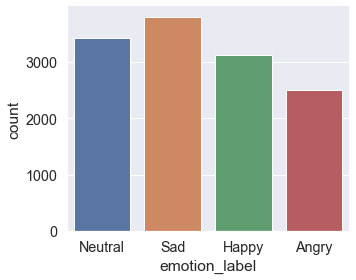

In [4]:
mapping = {
    3: 'Sad',
    0: 'Neutral',
    1: 'Happy',
    2: 'Angry'
}

def mappingToEmotion(value):
    return mapping[value]

df['emotion_label'] = df['emotion'].apply(mappingToEmotion) 
target_dist = sns.catplot(x="emotion_label", data=df, kind="count", height=4, aspect=1.2)
plt.show();

Ta xây dựng một lớp `Counting` để rút ra các features từ các sentences:
1. count_words: Số lượng từ trong một câu.
2. count_capital: Số lượng từ mà viết hoa trong một câu.
3. count_excl_quest: Số lượng dấu chấm hỏi và dấu chấm than.
4. count_positive_emojis: Số lượng emojis tích cực.
5. count_negative_emojis: Số lượng emojis tiêu cực.

In [5]:
class Counting(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, sentence):
        return len(re.findall(pattern, sentence))
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_capital = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_positive_emojis = X.apply(lambda x: self.count_regex(r'[:=x][)D]', x))
        count_negative_emojis = X.apply(lambda x: self.count_regex(r'[:]\'?[(]', x))
        
        df = pd.DataFrame({
                            'count_words': count_words
                            , 'count_capital': count_capital
                            , 'count_excl_quest': count_excl_quest
                            , 'count_positive_emojis': count_positive_emojis
                            , 'count_negative_emojis': count_negative_emojis
                          })
        
        return df

In [6]:
tc = Counting()
df_counts = tc.fit_transform(df['text'])
df_counts['emotion_label'] = df['emotion_label']

In [7]:
def plt_hist(df, col, max_bin=None):
    if max_bin == None:
        max_bin = df[col].max() + 1
    print('Mô tả cho cột {}'.format(col))
    print()
    print(df.groupby('emotion_label')[col].describe())
    bins = np.arange(df[col].min(), max_bin)
    g = sns.FacetGrid(df, col='emotion_label', height=5, hue='emotion_label')
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Mô tả cho cột count_words

                count       mean        std  min  25%  50%   75%    max
emotion_label                                                          
Angry          2502.0  13.331735  17.268034  0.0  5.0  8.0  15.0  272.0
Happy          3128.0   9.584399  14.001390  0.0  3.0  6.0  11.0  372.0
Neutral        3436.0  10.584109  15.369232  0.0  5.0  8.0  12.0  501.0
Sad            3798.0  12.285677  16.344083  0.0  5.0  8.0  14.0  288.0


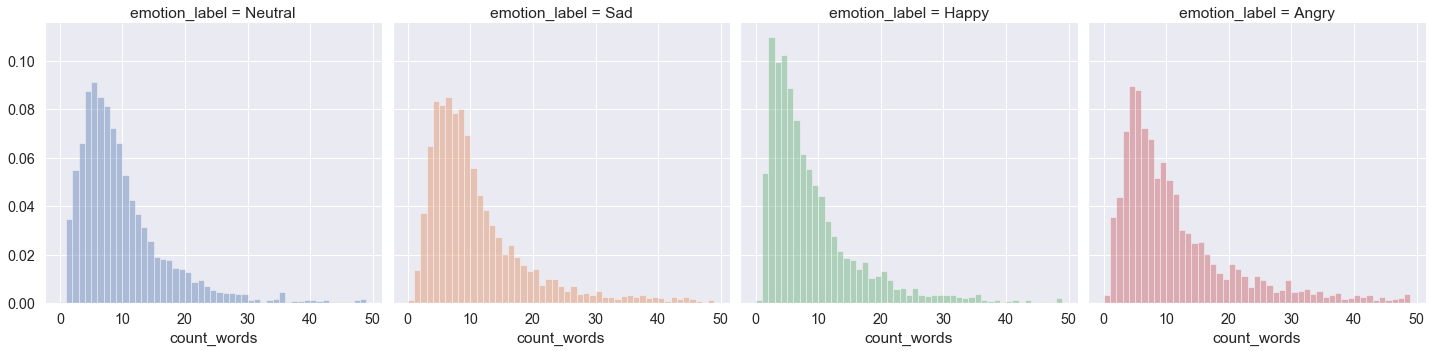

In [8]:
plt_hist(df_counts, col='count_words', max_bin=50)

Mô tả cho cột count_positive_emojis

                count      mean       std  min  25%  50%  75%   max
emotion_label                                                      
Angry          2502.0  0.003197  0.056467  0.0  0.0  0.0  0.0   1.0
Happy          3128.0  0.073210  0.351449  0.0  0.0  0.0  0.0  11.0
Neutral        3436.0  0.004366  0.065937  0.0  0.0  0.0  0.0   1.0
Sad            3798.0  0.003686  0.064809  0.0  0.0  0.0  0.0   2.0


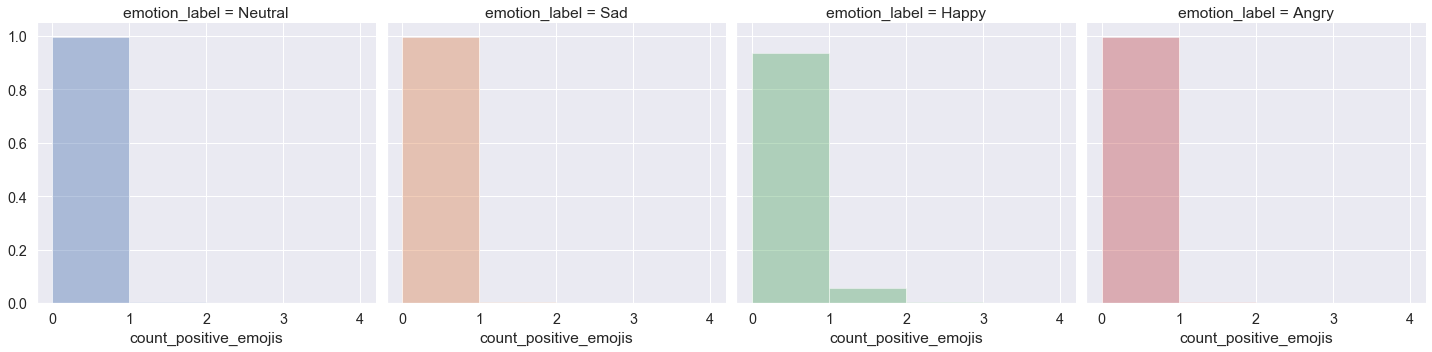

In [9]:
plt_hist(df_counts, col='count_positive_emojis', max_bin=5)

Mô tả cho cột count_negative_emojis

                count      mean       std  min  25%  50%  75%  max
emotion_label                                                     
Angry          2502.0  0.000799  0.028267  0.0  0.0  0.0  0.0  1.0
Happy          3128.0  0.000320  0.017880  0.0  0.0  0.0  0.0  1.0
Neutral        3436.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Sad            3798.0  0.017378  0.138517  0.0  0.0  0.0  0.0  3.0


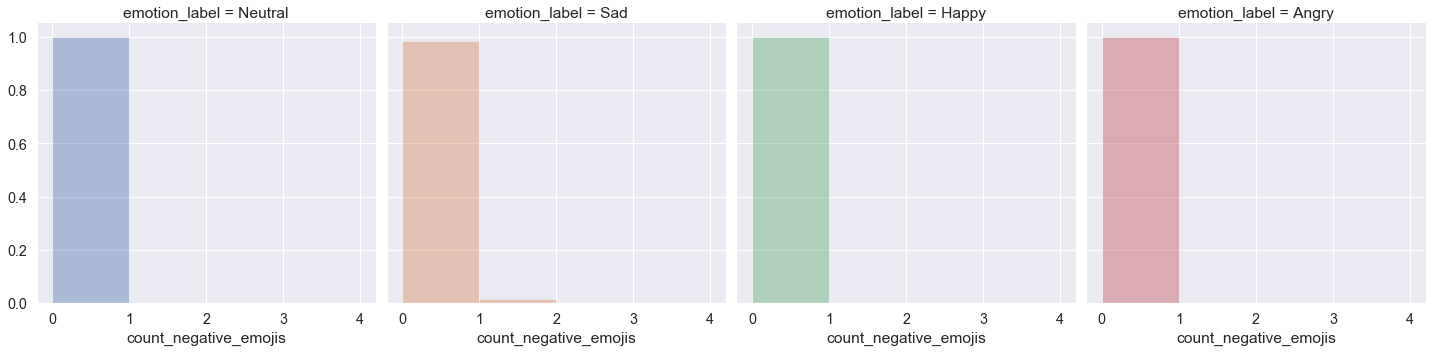

In [10]:
plt_hist(df_counts, col='count_negative_emojis', max_bin=5)

Mô tả cho cột count_excl_quest

                count      mean       std  min  25%  50%  75%   max
emotion_label                                                      
Angry          2502.0  0.578737  2.812265  0.0  0.0  0.0  0.0  82.0
Happy          3128.0  0.510230  1.992123  0.0  0.0  0.0  0.0  64.0
Neutral        3436.0  0.304715  0.913104  0.0  0.0  0.0  0.0  12.0
Sad            3798.0  0.291732  1.125840  0.0  0.0  0.0  0.0  36.0


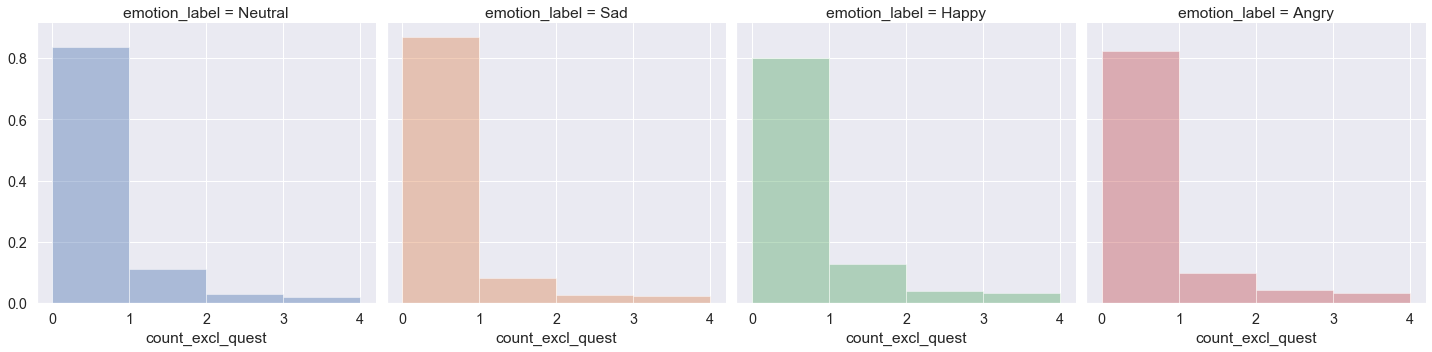

In [11]:
plt_hist(df_counts, col='count_excl_quest', max_bin=5)

Mô tả cho cột count_capital

                count      mean       std  min  25%  50%  75%    max
emotion_label                                                       
Angry          2502.0  0.757394  4.060800  0.0  0.0  0.0  0.0  110.0
Happy          3128.0  0.270460  1.530961  0.0  0.0  0.0  0.0   35.0
Neutral        3436.0  0.336438  1.645697  0.0  0.0  0.0  0.0   40.0
Sad            3798.0  0.406793  2.340993  0.0  0.0  0.0  0.0   97.0


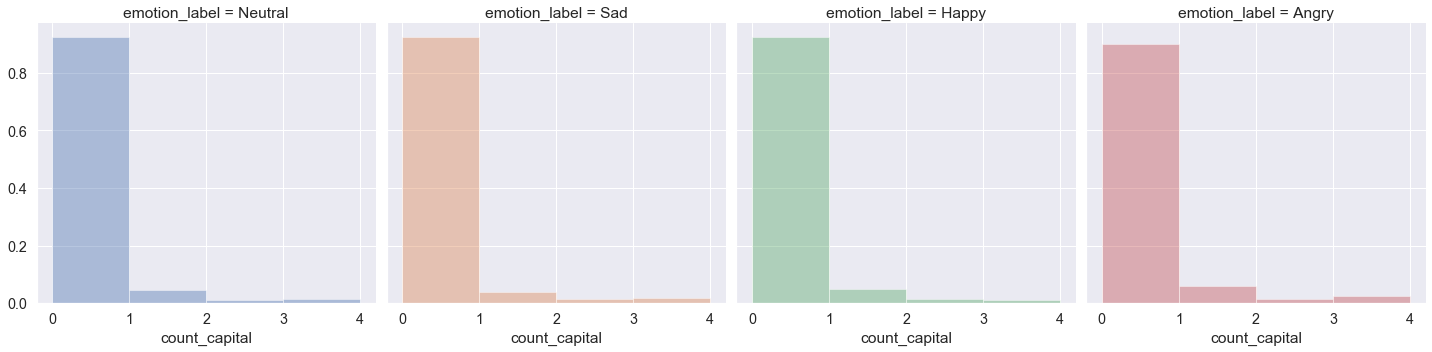

In [12]:
plt_hist(df_counts, col='count_capital', max_bin=5)

### Nhận xét
- `count_words`: Ta có thể thấy, những câu angry thường có số lượng từ nhiều hơn.
- `count_positive_emojis`: Đúng như nhóm dự đoán, những emoji tích cực sẽ tập trung ở label happy nhiều nhất, nhưng ở mỗi câu thì sẽ không chắc có emoji nên ở happy `mean` = 0.073
- `count_negative_emojis`: Tương tự như positive emojis, negative emoji sẽ tập trung ở sad nhiều nhất, `mean` = 0.017
- `count_excl_quest` và `count_capital`: Số lượng dấu chấm hỏi, dấu chấm than, và số lượng từ được in hoa sẽ xuất hiện nhiều nhất hơn emotion angry.

Nhóm sẽ quyết định giữ lại 5 thuộc tính này cho việc prediction.

### Clean the sentence

Sau khi có nhiều góc nhìn về dữ liệu và extract được 5 feature ở trên. Nhóm quyết định sử dụng tư tưởng Bag Of Word (BOW) để áp dụng vào field `text`. Nhưng với field `text` hiện tại có nhiều kí tự đặc biệt, nhiều từ viết hoa, nhiều từ sai chính tả, và có nhiều stop word (the, a, an, he, she, ...). Nên nhóm quyết định thực hiện clean sentence với các bước sau đây:

- Convert sentence to lowercase.
- Chỉ giữ lại chữ cái (bỏ số, bỏ dấu câu).
- Chuyển những từ sai chính tả thành những từ map với `glove_dict`.
- Xóa tất cả các stop words dựa vào thư viện `nltk.corpus`.

In [13]:
class MakeCleanText(BaseEstimator, TransformerMixin):
    def normalize(self, x):
        try:
            x = x.lower().strip()
        except:
            return ''
        ans = ''
        for i in x:
            if 'a' <= i <= 'z' or i == ' ':
                ans += i
        return ans
    
    def keep_clean(self, sentence):
        sentence = sentence.strip()
        return ' '.join(sentence.split())
    
    def only_keep_alphabets(self, sentence):
        return self.normalize(sentence)
    
    def remove_spaces(self, sentence):
        return self.keep_clean(sentence)
    
    def translate_unknow_word(self, sentence):
        new_line = ''
        for word in sentence.split():
            if word not in glove_dict:
                print(word)
                glove_dict[word] = input(word + ' ')
                open("dictionary.txt", "w").write(json.dumps(glove_dict))
            else:
                new_line += ' ' + glove_dict[word]

        return new_line
    
    def remove_stop_word(self, sentence):
        stopwords_list = stopwords.words('english')
        words = sentence.split()
        keep_words = ['not', 'no']
        clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1]
        clean_words += keep_words
        return " ".join(clean_words)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_new = X.copy()
        
        clean_texts = X_new['text'].apply(self.only_keep_alphabets).apply(self.translate_unknow_word).apply(self.only_keep_alphabets).apply(self.remove_spaces).apply(self.remove_stop_word)
        
        X_new['text'] = clean_texts
        
        return X_new

class FilterEmptyText(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[X['text'] != '']

Vì sau khi đã bỏ stop word nên sẽ có vài sentences không có từ nào trong câu. Trong pipeline nhóm đã thêm một class FilterEmptyText để lọc bỏ tất cả những câu rỗng. Sau đó transform dữ liệu và lưu trong field `clean_text` của df.

In [14]:
preprocess = Pipeline([
    ('mkclean', MakeCleanText()),
    ('rmempty', FilterEmptyText())
])

preprocess_df = preprocess.fit_transform(df)

In [15]:
df['clean_text'] = preprocess_df['text']
df.head()

,text,emotion,emotion_label,clean_text
10134,Damn sweetest couple ive ever watched,0,Neutral,damn sweetest couple ive ever watched not no
11006,"Nate: ""ha....heartbroken"" I felt that",3,Sad,nate heart broken felt not no
7468,It's so sweet.,1,Happy,sweet not no
2413,"Love, 06:33 na mahal magsimba muna ako love l ...",1,Happy,love na mahal muna ako love love sweetheart lo...
8867,This is something I'm gona try,0,Neutral,something im gona try not no


Để có cái nhìn rõ hơn về tần suất xuất hiện của các từ trong dataset, nhóm visualize lại biểu đồ cột, trục x là trục biểu thị cho loại từ và y là số lần từ đó xuất hiện trong dataset.

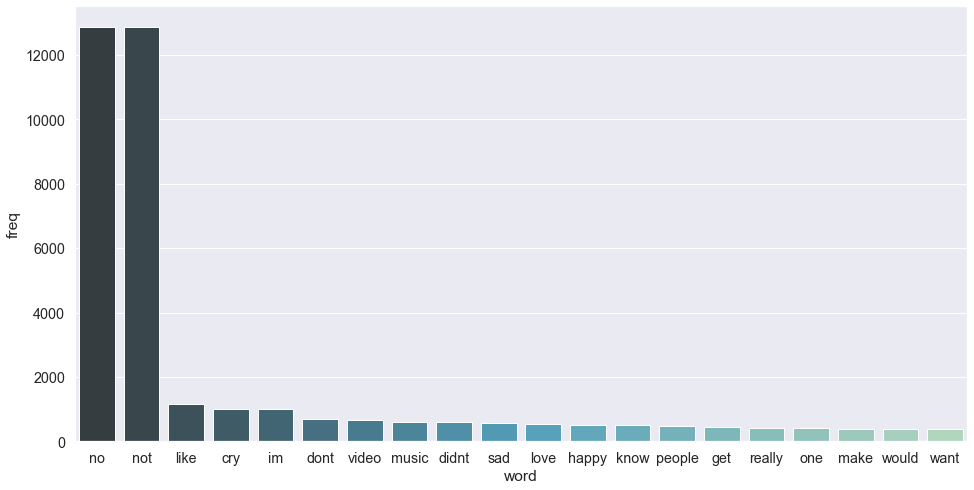

In [16]:
sr_clean = df['clean_text']

count_vect = CountVectorizer()
bow = count_vect.fit_transform(sr_clean.values.astype('U'))
word_freq = dict(zip(count_vect.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(16, 8))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="GnBu_d", ax=ax)
plt.show();

In [17]:
X = df_counts.copy()
X['clean_text'] = df['clean_text'].values.astype('U')

X = X.drop('emotion_label', axis=1)
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

X_train.head()

,count_words,count_capital,count_excl_quest,count_positive_emojis,count_negative_emojis,clean_text
4862,2,0,0,0,0,fk not no
10179,8,0,0,0,0,plz tell name intro song not no
8695,3,0,0,0,0,okay ded not no
2823,17,0,0,0,0,calming smoothing music making day live happy ...
7025,2,0,0,0,0,please like not no


In [18]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [19]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None):
    
    textcountscols = [
        'count_negative_emojis',
        'count_positive_emojis',
        'count_excl_quest',
        'count_capital',
        'count_words'
    ]
    
    # Tạo pipeline chuyển 'clean_text' sang BOW hay TFIDF
    cleanTextPipeline = Pipeline(
        steps=[
            ('cleantext', ColumnExtractor(cols='clean_text')), 
            ('vect', vect)
        ]
    )
    
    features = FeatureUnion(
        transformer_list=[
            ('textcounts', ColumnExtractor(cols=textcountscols)), 
            ('pipe', cleanTextPipeline)
        ],
        
        # Sử dụng tất cả CPUs
        n_jobs=-1
    )

    
    pipeline = Pipeline([
        ('features', features),
        ('clf', clf)
    ])
    
    # Kết hợp parameters_text (của BOW hay TTFIDF) và parameters_clf (hyper parameter của classifier)
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    # Best CV score = mean(cross-validated scored of best estimator)
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [20]:
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


parameters_logreg = {
    # Inverse of regularization strength; must be a positive float. Like in support vector machines, 
    # smaller values specify stronger regularization.
    'clf__C': (0.5, 1.0),
}

parameters_sgd = {
    'clf__alpha': (1e-2, 1e-3, 1e-4),
    'clf__penalty': ('l1', 'l2'),
    'clf__loss': ('hinge', 'log')
}

In [21]:
mnb = MultinomialNB()
logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=100, penalty='l2')
sgd = SGDClassifier(max_iter=100)

countvect = CountVectorizer()
tfidfvect = TfidfVectorizer()

In [22]:
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   29.0s finished


done in 29.946s

Best CV score: 0.605
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.619


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.61      0.57      0.59       672
           1       0.69      0.64      0.67       633
           2       0.54      0.52      0.53       500
           3       0.62      0.71      0.66       768

    accuracy                           0.62      2573
   macro avg       0.62      0.61      0.61      2573
weighted avg       0.62      0.62      0.62      2573



In [23]:
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.5, 1.0),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.4min finished
C:\Users\LAP11121-local\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


done in 273.422s

Best CV score: 0.628
Best parameters set:
	clf__C: 1.0
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.625


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.54      0.64      0.58       672
           1       0.70      0.65      0.67       633
           2       0.57      0.48      0.52       500
           3       0.69      0.68      0.69       768

    accuracy                           0.63      2573
   macro avg       0.62      0.61      0.62      2573
weighted avg       0.63      0.63      0.63      2573



In [24]:
best_sgd_countvect = grid_vect(sgd, parameters_sgd, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.01, 0.001, 0.0001),
 'clf__loss': ('hinge', 'log'),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  3.9min finished


done in 235.226s

Best CV score: 0.615
Best parameters set:
	clf__alpha: 0.0001
	clf__loss: 'hinge'
	clf__penalty: 'l1'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.615


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       672
           1       0.64      0.71      0.67       633
           2       0.53      0.52      0.53       500
           3       0.69      0.65      0.67       768

    accuracy                           0.61      2573
   macro avg       0.61      0.61      0.61      2573
weighted avg       0.62      0.61      0.61      2573



In [25]:
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   26.1s finished


done in 27.292s

Best CV score: 0.593
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.600


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.58      0.58      0.58       672
           1       0.67      0.61      0.64       633
           2       0.55      0.44      0.49       500
           3       0.59      0.72      0.65       768

    accuracy                           0.60      2573
   macro avg       0.60      0.59      0.59      2573
weighted avg       0.60      0.60      0.60      2573



In [26]:
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.5, 1.0),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.4min finished
C:\Users\LAP11121-local\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


done in 264.388s

Best CV score: 0.618
Best parameters set:
	clf__C: 1.0
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.610


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.51      0.66      0.58       672
           1       0.70      0.61      0.65       633
           2       0.57      0.49      0.53       500
           3       0.68      0.64      0.66       768

    accuracy                           0.61      2573
   macro avg       0.62      0.60      0.61      2573
weighted avg       0.62      0.61      0.61      2573



In [27]:
best_sgd_countvect = grid_vect(sgd, parameters_sgd, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.01, 0.001, 0.0001),
 'clf__loss': ('hinge', 'log'),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  3.2min finished


done in 190.512s

Best CV score: 0.598
Best parameters set:
	clf__alpha: 0.0001
	clf__loss: 'log'
	clf__penalty: 'l1'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.563


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.68      0.31      0.42       672
           1       0.54      0.79      0.64       633
           2       0.42      0.62      0.50       500
           3       0.72      0.56      0.63       768

    accuracy                           0.56      2573
   macro avg       0.59      0.57      0.55      2573
weighted avg       0.61      0.56      0.55      2573

